In [1]:
import numpy as np
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as colors
from static_probabilities import TRANSITION_PROBABILITIES_12UL, EMISSION_PROBABILITIES_12UL, START_PROBABILITIES_12UL
from time import time
from collections import Counter

In [21]:
def plot_matrix(matrix):
    plt.imshow(matrix, interpolation='none', cmap=colormaps["autumn"], norm=colors.PowerNorm(0.1))
    for (j,i),label in np.ndenumerate(matrix):
        plt.text(i,j,round(label, 3),ha='center',va='center')
    plt.show()

# Fetching Data

In [117]:
from requests import get as _get
from os.path import isfile
import json

BASE_URL = 'http://localhost:8080'


def get(url: str) -> list:
    l = None
    if isfile(f"{url}.json"):
        with open(f"{url}.json", "r") as file:
            l = json.loads(file.read())
    else:
        l = _get(f'{BASE_URL}/{url}').json()
        with open(f"{url}.json", "w") as file:
            file.write(json.dumps(l))
    
    print(l[0])
    print(f'Fetched {len(l)} items')
    return l

In [118]:
detections = sorted(get('detection'), key=lambda x: x["timestamp"])

{'id': 479017, 'batonId': 15, 'stationId': 9, 'rssi': -95, 'battery': 92.0, 'uptimeMs': 554087, 'remoteId': 1, 'timestamp': 1650975012000}
Fetched 2401946 items


In [119]:
batons = get('baton')

{'id': 2, 'name': 'O', 'mac': '5a:45:55:53:00:00'}
Fetched 22 items


In [120]:
baton_switchovers = sorted(get('batonswitchover'), key=lambda x: x["timestamp"])

{'id': 1, 'teamId': 1, 'previousBatonId': None, 'newBatonId': 23, 'timestamp': 1651012254359}
Fetched 73 items


In [121]:
stations = sorted(get('station'), key=lambda x: x["id"])

{'id': 2, 'name': 'station 1', 'distanceFromStart': 11.0, 'isBroken': False, 'url': 'http://172.12.50.101:8000'}
Fetched 7 items


In [122]:
teams = get('team')

{'id': 1, 'name': 'HILOK', 'batonId': 18}
Fetched 17 items


In [123]:
laps = get('accepted-laps')

{'id': 5096, 'teamId': 7, 'lapSourceId': 1, 'timestamp': 1651039200000}
Fetched 11294 items


# Processing data

In [124]:
team_detections: dict[int, list] = {team["id"]: [] for team in teams}
team_by_id: dict[int, dict] = {team["id"]: team for team in teams}
baton_team: dict[int, dict] = {}

switchover_index = 0
for detection in detections:
    while switchover_index < len(baton_switchovers) and baton_switchovers[switchover_index]["timestamp"] < detection[
        "timestamp"]:
        switchover = baton_switchovers[switchover_index]
        baton_team[switchover["newBatonId"]] = team_by_id[switchover["teamId"]]
        switchover_index += 1

    if detection["batonId"] in baton_team:
        if detection["rssi"] > -75:
            current_detections = team_detections[baton_team[detection["batonId"]]["id"]]
            if len(current_detections) > 0 and current_detections[-1]["timestamp"] == detection["timestamp"]:
                if current_detections[-1]["rssi"] < detection["rssi"]:
                    current_detections[-1] = detection
            else:
                current_detections.append(detection)

In [125]:
print({k: len(v) for k, v in team_detections.items()})

{1: 14615, 3: 10031, 4: 7088, 5: 12250, 8: 12208, 9: 8541, 10: 11384, 11: 9841, 12: 9495, 13: 9145, 14: 8939, 17: 5951, 7: 8614, 22: 8477, 6: 8803, 2: 8146, 16: 7698}


# Fitted Viterbi Lapper

## Fitting HMM parameters

In [126]:
station_to_emission = {v: k for k, v in enumerate([station["id"] for station in stations])}
data = [[[station_to_emission[detection["stationId"]]] for detection in team_detections[i]] for i in team_detections.keys()]
np_data = np.concatenate(data)
lengths = [len(x) for x in data]

transmat = np.array([
    [0.8, 0.1, 0., 0., 0., 0., 0.1],
    [0.1, 0.8, 0.1, 0., 0., 0., 0.],
    [0., 0.1, 0.8, 0.1, 0., 0., 0.],
    [0., 0., 0.1, 0.8, 0.1, 0., 0.],
    [0., 0., 0., 0.1, 0.8, 0.1, 0.],
    [0., 0., 0., 0., 0.1, 0.8, 0.1],
    [0.1, 0., 0., 0., 0., 0.1, 0.8]
])
emissionprob = np.array([
    [0.76, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.76, 0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.76, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.76, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.76, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.76, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.76],
])

model = hmm.CategoricalHMM(n_components=7, n_iter=1000, init_params="",implementation="scaling")
model.transmat_ = TRANSITION_PROBABILITIES_12UL.copy()
model.emissionprob_ = EMISSION_PROBABILITIES_12UL.copy()
model.startprob_ = START_PROBABILITIES_12UL.copy()
model.monitor_ = ConvergenceMonitor(model.monitor_.tol, model.monitor_.n_iter, model.monitor_.verbose)

model.fit(np_data, lengths)
model.monitor_

ConvergenceMonitor(
    history=[-232136.7089670681, -138009.67644158358, -132126.9133230959, -131222.2941249152, -131017.06538387935, -130925.98442776919, -130874.14486179927, -130842.21890781658, -130821.5507100981, -130807.63749877494, -130797.9116370544, -130791.03409869457, -130786.2368577599, -130782.88667240471, -130780.53132249678, -130778.86785807108, -130777.69108898863, -130776.85770985826, -130776.26541662289, -130775.84183811441, -130775.53672690819, -130775.31541683305, -130775.15385840432, -130775.0352089071, -130774.94756705887, -130774.88246029383, -130774.83381886237, -130774.79727010021, -130774.76964772631, -130774.74864784627, -130774.73258616078, -130774.72022565865, -130774.71065366703],
    iter=33,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)

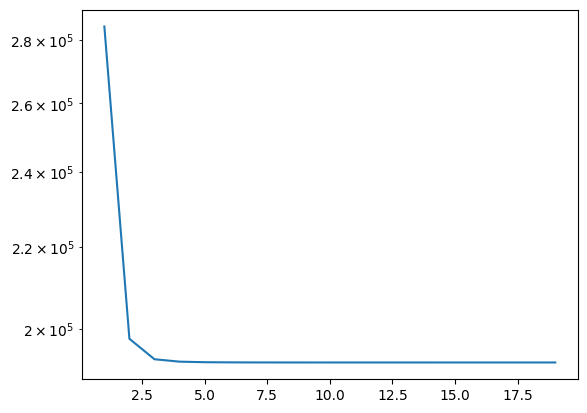

In [58]:
y = list(map(lambda x: -x, model.monitor_.history))
x = range(1, len(y)+1)
plt.plot(x, y)
plt.yscale('log', base=10)
plt.show()

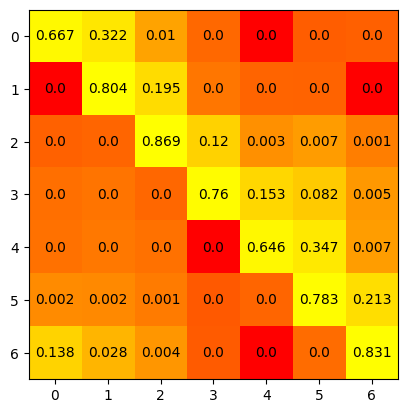

In [60]:
plot_matrix(model.transmat_)

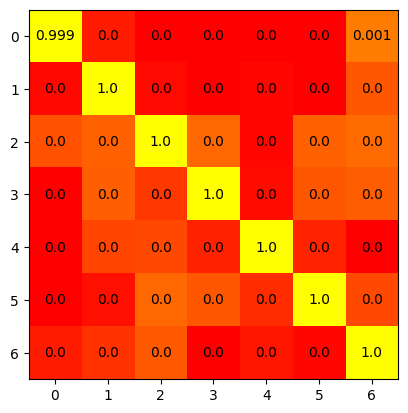

In [61]:
plot_matrix(model.emissionprob_)

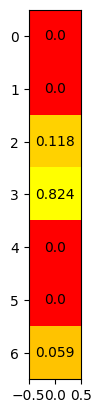

In [62]:
plot_matrix(np.array([model.startprob_]).reshape((7,1)))

## Counting Laps

In [127]:
model.decode(np.array([[station_to_emission[detection["stationId"]] for detection in team_detections[1]]]))

(-10946.790256255823, array([3, 4, 4, ..., 6, 0, 6]))

In [128]:
def find_next(s):
    return sorted([t for t in enumerate(model.transmat_[s])], key=lambda x: -x[1])[1][0]

segment_order = []
i = 0
for _ in range(7):
    segment_order.append(i)
    i = find_next(i)

tranlate_path = {v: i for i, v in enumerate(segment_order)}
tranlate_path = [0,1,2,3,4,5,6]

In [129]:
find_next(2)

3

In [130]:
start = time()

start_segment = list(model.startprob_).index(np.max(model.startprob_))
counts = []
half = 7//2

team_laps: dict[int, list[int]] = {}

for team in teams:
    _, path = model.decode(np.array([[station_to_emission[detection["stationId"]] for detection in team_detections[team["id"]]]]))
    path = list(map(lambda x: tranlate_path[x], path))
    count = 0
    prev = path[0]
    lap_times = []
    for i, segment in enumerate(path[1:]):
        delta = half - (half - (segment - prev)) % 7
        if delta > 0 and prev > segment:
            count += 1
            lap_times.append(team_detections[team["id"]][i+1]["timestamp"])
        elif delta < 0 and prev < segment:
            count -= 1
            if len(lap_times) > 0:
                lap_times.pop()
        prev = segment

    counts.append((team["name"], count))
    team_laps[team['id']] = lap_times

counts = sorted(counts, key=lambda x:x[1])

print(counts)
#print(team_laps)

labels = [l for l, _ in counts]
counts = [c for _, c in counts]

print(f'Took: {time() - start}')

[('Antilopen', 522), ('Lila - VDK', 542), ('Lombrosiana - VBK', 568), ('SK', 580), ('HILOK Ladies', 613), ('Blandinia', 618), ('VPPK', 621), ('VRG', 622), ('Politeia', 627), ('HK', 628), ('HERMES - GFK', 649), ('Wetenschappen', 662), ('VGK', 685), ('VEK - ML', 707), ('VLK', 764), ('VTK', 864), ('HILOK', 873)]
Took: 0.16130471229553223


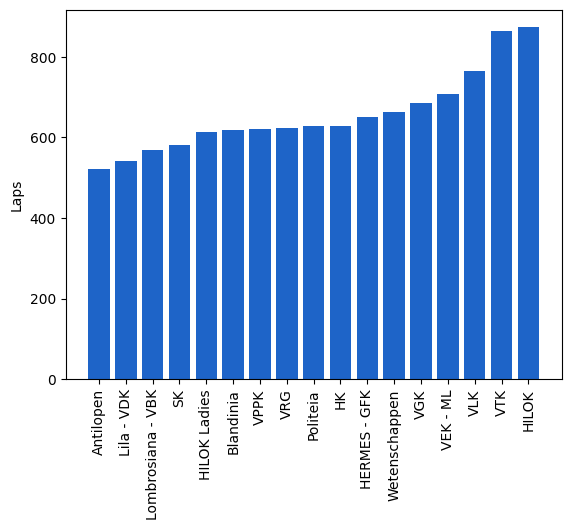

In [131]:
# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, counts,  color='#1E64C8')

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# Title
#plt.title("Laps per team")
plt.ylabel("Laps")
#plt.xlabel("Team")

# Show graphic
plt.show()

# Interval Lapper

In [172]:
station_to_emission = {v: k for k, v in enumerate([station["id"] for station in stations])}
team_all_detections: dict[int, list] = {team["id"]: [] for team in teams}
team_by_id: dict[int, dict] = {team["id"]: team for team in teams}
baton_team: dict[int, dict] = {}

switchover_index = 0
for detection in detections:
    while switchover_index < len(baton_switchovers) and baton_switchovers[switchover_index]["timestamp"] < detection[
        "timestamp"]:
        switchover = baton_switchovers[switchover_index]
        baton_team[switchover["newBatonId"]] = team_by_id[switchover["teamId"]]
        switchover_index += 1

    if detection["batonId"] in baton_team:
        current_detections = team_all_detections[baton_team[detection["batonId"]]["id"]]
        current_detections.append(detection)



interval = 5000  # 10s
counts = []
half = 7//2

for team in teams:
    intervals = [[]]
    for detection in team_all_detections[team["id"]]:
        if len(intervals[-1]) == 0 or detection["timestamp"] < intervals[-1][0]["timestamp"] + interval:
            intervals[-1].append(detection)
        else:
            intervals.append([detection])

    path = []
    for group in intervals:
        station = Counter(map(lambda x: x["stationId"], group)).most_common(1)[0][0]
        path.append(station_to_emission[station])

    count = 0
    prev = path[0]
    lap_times = []
    for i, segment in enumerate(path[1:]):
        delta = half - (half - (segment - prev)) % 7
        if delta > 0 and prev > segment:
            count += 1
            #lap_times.append(team_detections[team["id"]][i+1]["timestamp"])
        elif delta < 0 and prev < segment:
            count -= 1
            #lap_times.pop()
        prev = segment

    counts.append((team["name"], count))

counts = sorted(counts, key=lambda x:x[1])

print(counts)

[('HILOK Ladies', 331), ('Lila - VDK', 557), ('Antilopen', 560), ('Lombrosiana - VBK', 581), ('SK', 588), ('Blandinia', 622), ('VPPK', 628), ('HK', 628), ('VRG', 629), ('Politeia', 634), ('VGK', 643), ('HERMES - GFK', 650), ('Wetenschappen', 668), ('VEK - ML', 732), ('VLK', 777), ('VTK', 859), ('HILOK', 876)]


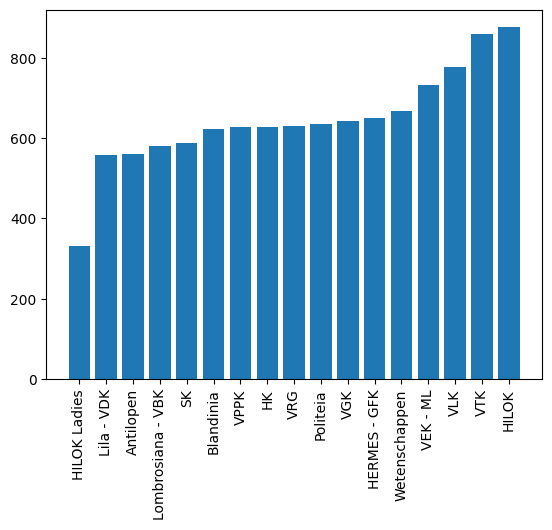

In [173]:


labels = [l for l, _ in counts]
counts = [c for _, c in counts]

# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, counts)

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# Show graphic
plt.show()

# Static Parameters visualisation

In [32]:
model = hmm.CategoricalHMM(n_components=7, n_iter=1000, init_params="s")
model.transmat_ = TRANSITION_PROBABILITIES_12UL.copy()
model.emissionprob_ = EMISSION_PROBABILITIES_12UL.copy()
model.startprob_ = START_PROBABILITIES_12UL.copy()

model.score(np_data, lengths)

-232136.70896702813

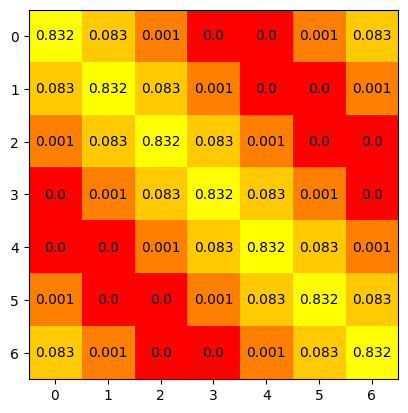

In [33]:
plot_matrix(model.transmat_)

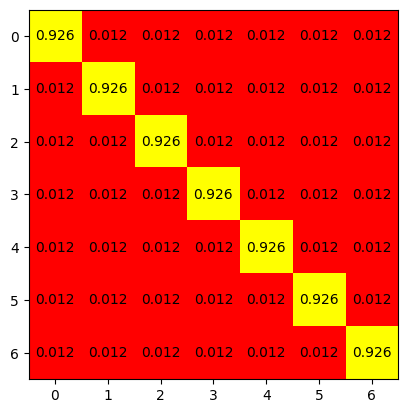

In [34]:
plot_matrix(model.emissionprob_)

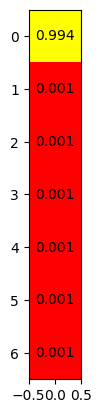

In [35]:
plot_matrix(np.array([model.startprob_]).reshape((7,1)))

# Varia

In [71]:
urenloop_count = [{"count": 875, "team": {"id": 1, "name": "HILOK"}}, {"count": 777, "team": {"id": 3, "name": "VLK"}}, {"count": 669, "team": {"id": 4, "name": "Wetenschappen"}}, {"count": 629, "team": {"id": 5, "name": "VRG"}}, {"count": 649, "team": {"id": 8, "name": "HERMES - GFK"}}, {"count": 553, "team": {"id": 9, "name": "Lila - VDK"}}, {"count": 626, "team": {"id": 10, "name": "VPPK"}}, {"count": 730, "team": {"id": 11, "name": "VEK - ML"}}, {"count": 631, "team": {"id": 12, "name": "HK"}}, {"count": 565, "team": {"id": 13, "name": "Lombrosiana - VBK"}}, {"count": 622, "team": {"id": 14, "name": "Blandinia"}}, {"count": 528, "team": {"id": 17, "name": "Antilopen"}}, {"count": 642, "team": {"id": 7, "name": "Politeia"}}, {"count": 613, "team": {"id": 22, "name": "HILOK Ladies"}}, {"count": 740, "team": {"id": 6, "name": "VGK"}}, {"count": 868, "team": {"id": 2, "name": "VTK"}}, {"count": 577, "team": {"id": 16, "name": "SK"}}]

# eventual count with all sources addes
urenloop_count = {entry["team"]["name"]: entry["count"] for entry in urenloop_count}

# Only viterbi count - without manual data
# urenloop_count = {team["name"]: len([lap["timestamp"] for lap in laps if lap["teamId"] == team["id"] and lap["lapSourceId"] == 3]) for team in teams}

own_count = [('Lila - VDK', 555), ('Antilopen', 556), ('Lombrosiana - VBK', 581), ('SK', 589), ('HILOK Ladies', 615), ('Blandinia', 622), ('VPPK', 628), ('HK', 628), ('VRG', 629), ('Politeia', 642), ('HERMES - GFK', 649), ('Wetenschappen', 668), ('VEK - ML', 729), ('VGK', 741), ('VLK', 776), ('VTK', 870), ('HILOK', 876)]
own_count = [('Lila - VDK', 556), ('Antilopen', 556), ('Lombrosiana - VBK', 581), ('SK', 589), ('HILOK Ladies', 614), ('Blandinia', 622), ('VPPK', 628), ('HK', 628), ('VRG', 629), ('Politeia', 642), ('HERMES - GFK', 649), ('Wetenschappen', 668), ('VEK - ML', 729), ('VGK', 741), ('VLK', 776), ('VTK', 870), ('HILOK', 876)]

# old (1s)
#own_count = [('Antilopen', 522), ('Lila - VDK', 542), ('Lombrosiana - VBK', 568), ('SK', 580), ('HILOK Ladies', 613), ('Blandinia', 618), ('VPPK', 621), ('VRG', 622), ('Politeia', 627), ('HK', 628), ('HERMES - GFK', 649), ('Wetenschappen', 662), ('VGK', 685), ('VEK - ML', 707), ('VLK', 764), ('VTK', 864), ('HILOK', 873)]
own_count = {entry[0]: entry[1] for entry in own_count}

diff = {k: v-urenloop_count[k] for k, v in own_count.items()}
diff

{'Lila - VDK': 3,
 'Antilopen': 28,
 'Lombrosiana - VBK': 16,
 'SK': 12,
 'HILOK Ladies': 1,
 'Blandinia': 0,
 'VPPK': 2,
 'HK': -3,
 'VRG': 0,
 'Politeia': 0,
 'HERMES - GFK': 0,
 'Wetenschappen': -1,
 'VEK - ML': -1,
 'VGK': 1,
 'VLK': -1,
 'VTK': 2,
 'HILOK': 1}

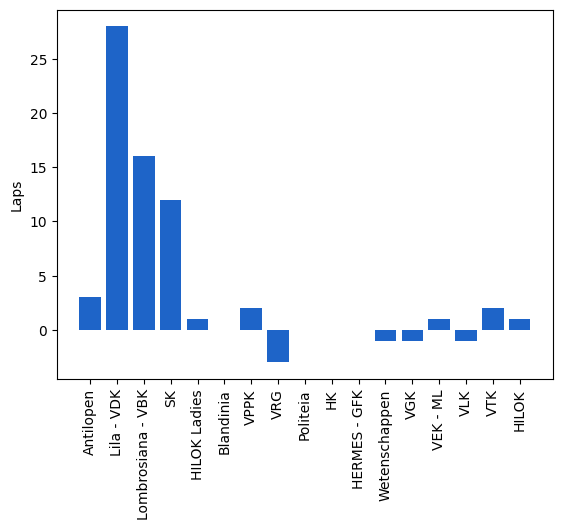

In [72]:
# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, diff.values(),  color='#1E64C8')

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# Title
#plt.title("Lap difference compared to 2022 final scoreboard")
plt.ylabel("Laps")
#plt.xlabel("Team")

# Show graphic
plt.show()

# Varia

In [133]:
urenloop_count = [{"count": 875, "team": {"id": 1, "name": "HILOK"}}, {"count": 777, "team": {"id": 3, "name": "VLK"}}, {"count": 669, "team": {"id": 4, "name": "Wetenschappen"}}, {"count": 629, "team": {"id": 5, "name": "VRG"}}, {"count": 649, "team": {"id": 8, "name": "HERMES - GFK"}}, {"count": 553, "team": {"id": 9, "name": "Lila - VDK"}}, {"count": 626, "team": {"id": 10, "name": "VPPK"}}, {"count": 730, "team": {"id": 11, "name": "VEK - ML"}}, {"count": 631, "team": {"id": 12, "name": "HK"}}, {"count": 565, "team": {"id": 13, "name": "Lombrosiana - VBK"}}, {"count": 622, "team": {"id": 14, "name": "Blandinia"}}, {"count": 528, "team": {"id": 17, "name": "Antilopen"}}, {"count": 642, "team": {"id": 7, "name": "Politeia"}}, {"count": 613, "team": {"id": 22, "name": "HILOK Ladies"}}, {"count": 740, "team": {"id": 6, "name": "VGK"}}, {"count": 868, "team": {"id": 2, "name": "VTK"}}, {"count": 577, "team": {"id": 16, "name": "SK"}}]

# eventual count with all sources addes
#urenloop_count = {entry["team"]["name"]: entry["count"] for entry in urenloop_count}

# Only viterbi count - without manual data
urenloop_count = {team["name"]: len([lap["timestamp"] for lap in laps if lap["teamId"] == team["id"] and lap["lapSourceId"] == 3]) for team in teams}
print(urenloop_count)

own_count = [('Antilopen', 522), ('Lila - VDK', 542), ('Lombrosiana - VBK', 568), ('SK', 580), ('HILOK Ladies', 613), ('Blandinia', 618), ('VPPK', 621), ('VRG', 622), ('Politeia', 627), ('HK', 628), ('HERMES - GFK', 649), ('Wetenschappen', 662), ('VGK', 685), ('VEK - ML', 707), ('VLK', 764), ('VTK', 864), ('HILOK', 873)]

# old (1s)
#own_count = [('HILOK Ladies', 331), ('Lila - VDK', 557), ('Antilopen', 560), ('Lombrosiana - VBK', 581), ('SK', 588), ('Blandinia', 622), ('VPPK', 628), ('HK', 628), ('VRG', 629), ('Politeia', 634), ('VGK', 643), ('HERMES - GFK', 650), ('Wetenschappen', 668), ('VEK - ML', 732), ('VLK', 777), ('VTK', 859), ('HILOK', 876)]

own_count = {entry[0]: entry[1] for entry in own_count}

diff = {k: v-urenloop_count[k] for k, v in own_count.items()}
diff

{'HILOK': 875, 'VLK': 761, 'Wetenschappen': 660, 'VRG': 625, 'HERMES - GFK': 649, 'Lila - VDK': 549, 'VPPK': 616, 'VEK - ML': 697, 'HK': 629, 'Lombrosiana - VBK': 565, 'Blandinia': 619, 'Antilopen': 514, 'Politeia': 632, 'HILOK Ladies': 612, 'VGK': 692, 'VTK': 860, 'SK': 577}


{'Antilopen': 8,
 'Lila - VDK': -7,
 'Lombrosiana - VBK': 3,
 'SK': 3,
 'HILOK Ladies': 1,
 'Blandinia': -1,
 'VPPK': 5,
 'VRG': -3,
 'Politeia': -5,
 'HK': -1,
 'HERMES - GFK': 0,
 'Wetenschappen': 2,
 'VGK': -7,
 'VEK - ML': 10,
 'VLK': 3,
 'VTK': 4,
 'HILOK': -2}

In [134]:
urenloop_count

{'HILOK': 875,
 'VLK': 761,
 'Wetenschappen': 660,
 'VRG': 625,
 'HERMES - GFK': 649,
 'Lila - VDK': 549,
 'VPPK': 616,
 'VEK - ML': 697,
 'HK': 629,
 'Lombrosiana - VBK': 565,
 'Blandinia': 619,
 'Antilopen': 514,
 'Politeia': 632,
 'HILOK Ladies': 612,
 'VGK': 692,
 'VTK': 860,
 'SK': 577}

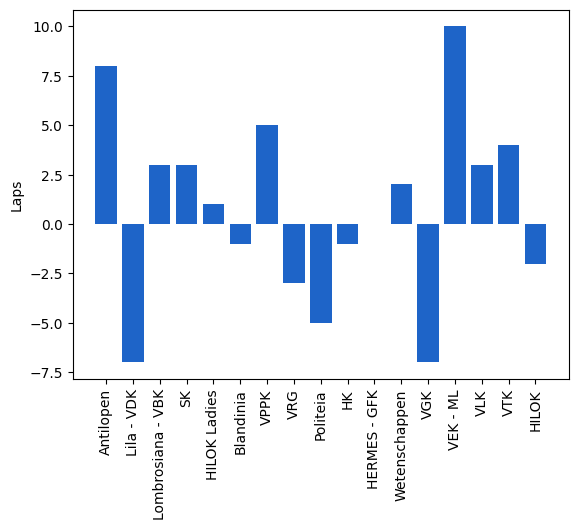

In [135]:
# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, diff.values(),  color='#1E64C8')

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# Title
#plt.title("Lap differences Found parameters compared to Static parameters")
plt.ylabel("Laps")
#plt.xlabel("Team")

# Show graphic
plt.show()

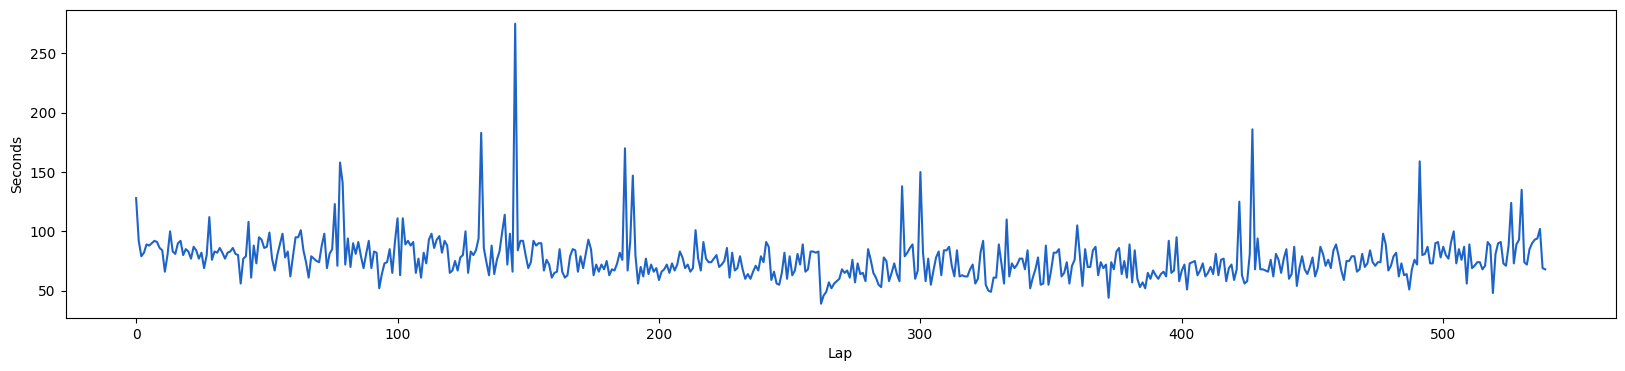

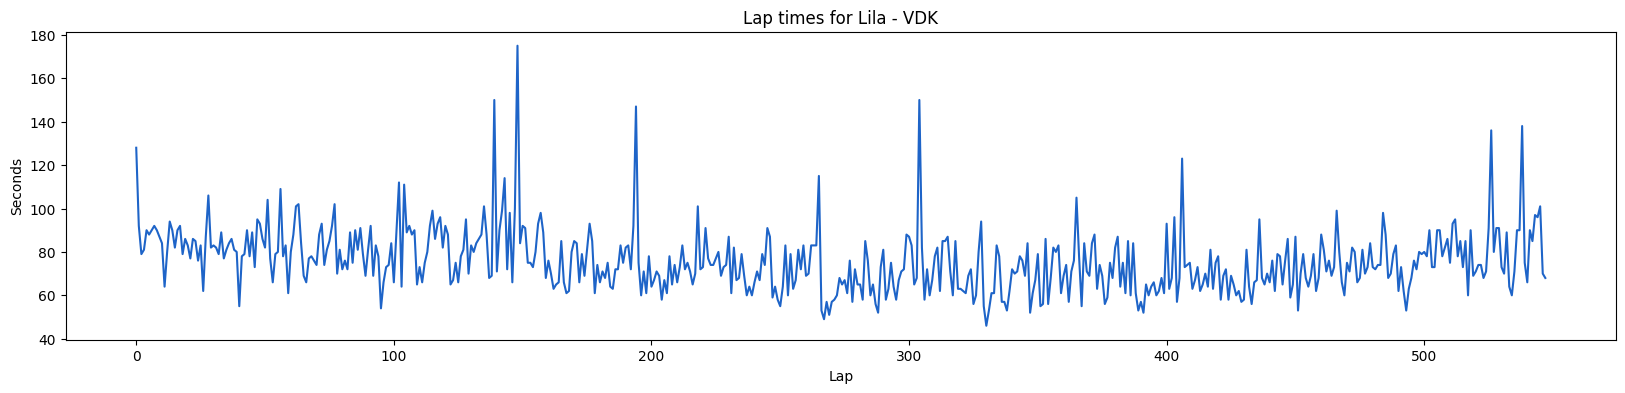

In [132]:
i = 9
relative_laptimes = []
prev = team_laps[i][0]
for t in team_laps[i][1:-1]:
    relative_laptimes.append((t-prev)/1000)
    prev = t

plt.figure(figsize=(20, 4))
#plt.title(f"Lap times for {team_by_id[i]['name']}")
plt.ylabel("Seconds")
plt.xlabel("Lap")
plt.plot(np.array(relative_laptimes),color='#1E64C8')
plt.show()

lapss = [lap["timestamp"] for lap in laps if lap["teamId"] == i and lap["lapSourceId"] == 3]

relative_laptimes = []
prev = lapss[0]
for t in lapss[1:]:
    relative_laptimes.append((t-prev)/1000)
    prev = t

plt.figure(figsize=(20, 4))
plt.title(f"Lap times for {team_by_id[i]['name']}")
plt.ylabel("Seconds")
plt.xlabel("Lap")
plt.plot(np.array(relative_laptimes), color='#1E64C8')
plt.show()

In [109]:
print(len([lap["timestamp"] for lap in laps if lap["teamId"] == 6 and lap["lapSourceId"] == 1]))

48


In [131]:
print(len([lap["timestamp"] for lap in laps if lap["teamId"] == 6 and lap["lapSourceId"] == 3]))

692


In [48]:
teams

[{'id': 1, 'name': 'HILOK', 'batonId': 18},
 {'id': 3, 'name': 'VLK', 'batonId': 12},
 {'id': 4, 'name': 'Wetenschappen', 'batonId': 6},
 {'id': 5, 'name': 'VRG', 'batonId': 9},
 {'id': 8, 'name': 'HERMES - GFK', 'batonId': 10},
 {'id': 9, 'name': 'Lila - VDK', 'batonId': 21},
 {'id': 10, 'name': 'VPPK', 'batonId': 19},
 {'id': 11, 'name': 'VEK - ML', 'batonId': 7},
 {'id': 12, 'name': 'HK', 'batonId': 13},
 {'id': 13, 'name': 'Lombrosiana - VBK', 'batonId': 2},
 {'id': 14, 'name': 'Blandinia', 'batonId': 4},
 {'id': 17, 'name': 'Antilopen', 'batonId': 16},
 {'id': 7, 'name': 'Politeia', 'batonId': 3},
 {'id': 22, 'name': 'HILOK Ladies', 'batonId': 8},
 {'id': 6, 'name': 'VGK', 'batonId': 17},
 {'id': 2, 'name': 'VTK', 'batonId': 15},
 {'id': 16, 'name': 'SK', 'batonId': 22}]

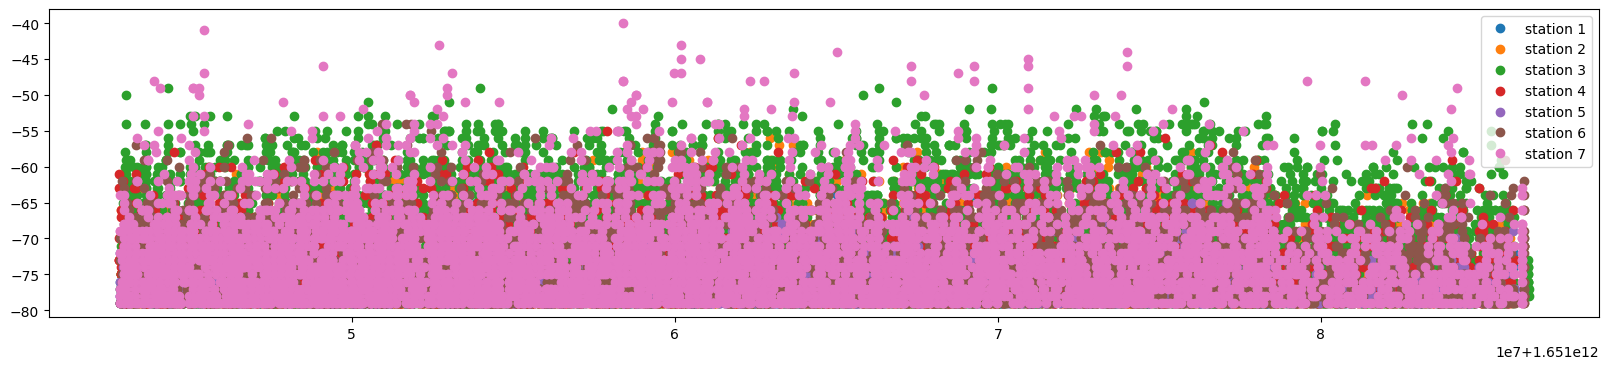

In [58]:
plt.figure(figsize=(20, 4))

for station in sorted(stations, key=lambda x: x["id"]):
    plt.plot(
        [detection["timestamp"] for detection in team_detections[6] if detection["stationId"] == station["id"]],
        [detection["rssi"] for detection in team_detections[6] if detection["stationId"] == station["id"]],
        'o', label=station["name"]
    )

plt.legend()
plt.show()